# Finite volume methods for the Darcy equation

In this tutorial we present how to solve a Darcy equation with [PorePy](https://github.com/pmgbergen/porepy) by using two finite volume methods: two-point flux approximation (TPFA) and multi-point flux approximation (MPFA).

## Exercise 1

We consider the primal formulation of the Darcy problem: the only unknown is the pressure $p$.
We want to solve the problem on different families of grids.

Let $\Omega = [0, 1]^2$ be the domain of interest with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k=I$ the matrix permeability and $f = 1$ the source term, we want to solve the following problem: find $p$ such that
$$
\nabla \cdot (- \nabla p) = f
\quad \text{in } \Omega
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial \Omega$$


We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules.

In [ ]:
import numpy as np

import porepy as pp
import pygeon as pg

We create now the grid, which could be: Cartesian, simplicial, Voronoi, or octagonal.

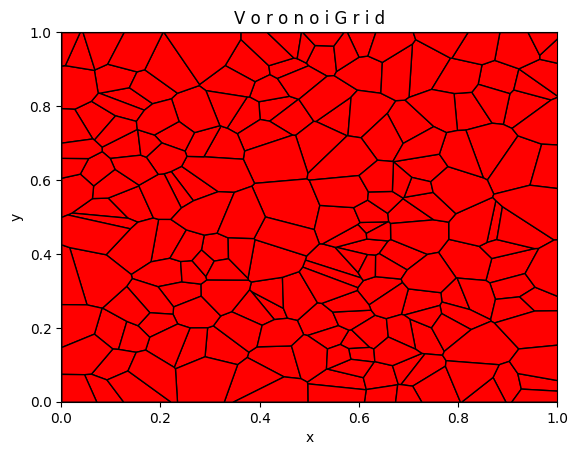

In [ ]:
dim = 2

# creation of a Cartesian grid
# sd = pp.CartGrid([25]*dim, [1]*dim)
# pg.convert_from_pp(sd)

# creation of a simplex grid
sd = pg.unit_grid(dim, 0.05, as_mdg=False)

# creation of a Voronoi grid (only 2d)
# sd = pg.VoronoiGrid(num_pts=200, seed=0)

# creation of an octagonal grid (only 2d)
# sd = pg.OctagonGrid([25]*dim, [1]*dim)

# compute the geometrical properties of the grid
sd.compute_geometry()

# represent the grid
# pp.plot_grid(sd, plot_2d=True)

With the following code we set the data, in particular the permeability tensor and the scalar source.

In [15]:
key = "flow"

# set up the data for the flow problem
data = {}

# Permeability
perm = pp.SecondOrderTensor(np.ones(sd.num_cells))

# Boundary conditions
b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]
bc = pp.BoundaryCondition(sd, b_faces, ["dir"] * b_faces.size)
bc_val = np.zeros(sd.num_faces)

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "bc": bc, "bc_values": bc_val}

data = pp.initialize_default_data(sd, {}, key, parameters)

Once the data are assigned to the grid, we need to construct the discrete problem. In particular, the linear system associated with the equation is given as
$$
A p = b
$$<br>
The right-hand side term $b$ includes the part associated with the scalar source term and with the boundary conditions, we construct first the former.

In [16]:
# construct the rhs from the discretization of the scalar source term
p0 = pg.PwConstants(key)
# NOTE: we do not use the mass matrix here, since PorePy uses a different convention for the scalar variables
scalar_source = p0.interpolate(sd, lambda _: 1)

Second, we construct the matrix $A$ from the TPFA approximation and the part of the right-hand side associated to the boundary conditions. We can compute the pressure $p$ by solving the linear system.

In [17]:
# construct the lhr and rhs from the discretization of the diffusion operator
tpfa = pp.Tpfa(key)
tpfa.discretize(sd, data)
A_tpfa, b_tpfa = tpfa.assemble_matrix_rhs(sd, data)


# solve the problem
ls = pg.LinearSystem(A_tpfa, b_tpfa + scalar_source)
cell_p_tpfa = ls.solve()

Alternatively to TPFA we can use the MPFA scheme to construct the matrix $A$, and associated right-hand side, and then compute the pressure $p$.

In [18]:
# construct the lhr and rhs from the discretization of the diffusion operator
mpfa = pp.Mpfa(key)
mpfa.discretize(sd, data)
A_mpfa, b_mpfa = mpfa.assemble_matrix_rhs(sd, data)

# solve the problem
ls = pg.LinearSystem(A_mpfa, b_mpfa + scalar_source)
cell_p_mpfa = ls.solve()

Let us compute the $L^2$-difference between the two solutions.

In [19]:
# compute the difference between the two solutions
diff = cell_p_tpfa - cell_p_mpfa

mass = p0.assemble_mass_matrix(sd)

norm_mpfa = np.sqrt(cell_p_mpfa.T @ mass @ cell_p_mpfa)
norm_diff = np.sqrt(diff.T @ mass @ diff) / norm_mpfa

print("difference", norm_diff, norm_diff / norm_mpfa)

difference 0.11787648709409212 0.01219729491306517


We export the solutions to be visualized by [ParaView](https://www.paraview.org/).

In [20]:
save = pp.Exporter(sd, "sol", folder_name="ex1")
save.write_vtu([("cell_p_tpfa", cell_p_tpfa), ("cell_p_mpfa", cell_p_mpfa)])